In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import os
import torchaudio


class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features, use_bias=True):
        super(GCNLayer, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(torch.zeros(size=(in_features, out_features))))
        if use_bias:
            self.bias = nn.Parameter(torch.FloatTensor(torch.zeros(size=(out_features,))))
        else:
            self.register_parameter('bias', None)

        self.initialize_weights()

    def initialize_weights(self):
        nn.init.xavier_uniform_(self.weight)
        if self.bias is not None:
            nn.init.zeros_(self.bias)

    def forward(self, x, adj):

        x = x @ self.weight
        if self.bias is not None:
            x += self.bias
        return torch.sparse.mm(adj, x)


class GCN(nn.Module):
    def __init__(self, node_features, hidden_dim, num_classes, dropout, use_bias=True):
        super(GCN, self).__init__()
        self.gcn_1 = GCNLayer(node_features, hidden_dim, use_bias)
        self.gcn_2 = GCNLayer(hidden_dim, num_classes, use_bias)
        self.dropout = nn.Dropout(p=dropout)

    def initialize_weights(self):
        self.gcn_1.initialize_weights()
        self.gcn_2.initialize_weights()

    def forward(self, x, adj,Inside = True):
      if Inside:
        num_channels,sequence_length,features = x.size()
        x_final = []
        for ch in range (num_channels):
          x1 = F.relu(self.gcn_1(x[ch], adj[ch]))
          x1 = self.dropout(x1)
          x1 = self.gcn_2(x1, adj[ch])
          x_final.append(x1)
        x_final = torch.stack(x_final).view(num_channels,sequence_length,-1)
        return x_final
      else:
        x1 = F.relu(self.gcn_1(x, adj))
        x1 = self.dropout(x1)
        x1 = self.gcn_2(x1, adj)
        return x1

x = torch.rand(18,240)
ADJ = torch.rand(18,18)
model = GCN(240,150,2,0.25)
#model.initialize_weights()
y = model(x,ADJ, False)
y.shape

torch.Size([18, 2])

In [ ]:
class GraphAttentionLayer(nn.Module):
    """
    Simple GAT layer, similar to https://arxiv.org/abs/1710.10903
    """
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GraphAttentionLayer, self).__init__()
        self.dropout = dropout
        self.in_features = in_features
        self.out_features = out_features
        self.alpha = alpha
        self.concat = concat

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)

        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, h, adj):
        Wh = torch.mm(h, self.W) # h.shape: (N, in_features), Wh.shape: (N, out_features)
        e = self._prepare_attentional_mechanism_input(Wh)
        zero_vec = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime = torch.matmul(attention, Wh)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

    def _prepare_attentional_mechanism_input(self, Wh):
        # Wh.shape (N, out_feature)
        # self.a.shape (2 * out_feature, 1)
        # Wh1&2.shape (N, 1)
        # e.shape (N, N)
        Wh1 = torch.matmul(Wh, self.a[:self.out_features, :])
        Wh2 = torch.matmul(Wh, self.a[self.out_features:, :])
        # broadcast add
        e = Wh1 + Wh2.T
        return self.leakyrelu(e)

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.in_features) + ' -> ' + str(self.out_features) + ')'

class GAT(nn.Module):
    def __init__(self, nfeat, nhid, dropout, alpha, nheads):
        """Dense version of GAT."""
        super(GAT, self).__init__()
        self.dropout = dropout

        self.attentions = [GraphAttentionLayer(nfeat, nhid, dropout=dropout, alpha=alpha, concat=True) for _ in range(nheads)]
        for i, attention in enumerate(self.attentions):
            self.add_module('attention_{}'.format(i), attention)

        #self.out_att = GraphAttentionLayer(nhid * nheads, nclass, dropout=dropout, alpha=alpha, concat=False)

    def forward(self, x, adj,Inside = True):
      if Inside:
        num_channels,sequence_length,features = x.size()
        X_Final = []
        for ch in range(num_channels):
          x1 = F.dropout(x[ch], self.dropout, training=self.training)
          x1 = torch.cat([att(x1, adj[ch]) for att in self.attentions], dim=1)
          x1 = F.dropout(x1, self.dropout, training=self.training)
          x1 = F.elu(x1)
          X_Final.append(x1)
        X_Final = torch.stack(X_Final)
        #x = F.elu(self.out_att(x, adj))
        return X_Final #F.log_softmax(x, dim=1)
      else :
          num_channels,sequence_length,features = x.size()
          x = x.view(num_channels,-1)
          x1 = F.dropout(x, self.dropout, training=self.training)
          x1 = torch.cat([att(x1, adj) for att in self.attentions], dim=1)
          x1 = F.dropout(x1, self.dropout, training=self.training)
          x1 = F.elu(x1)
          return x1

'''
x = torch.rand(18,1280)
ADJ = torch.rand(18,18)
model = GAT(1280,20,.25,0.5,12)
b = model(x,ADJ,False)
print(b.shape)
print(b)
'''

'\nx = torch.rand(18,1280)\nADJ = torch.rand(18,18)\nmodel = GAT(1280,20,.25,0.5,12)\nb = model(x,ADJ,False)\nprint(b.shape)\nprint(b)\n'

### Main Model

In [ ]:
class MainModel(nn.Module):
  def __init__(self,M,nfeat_inside, nfeat_outside,nhid_inside ,nhid_outside ,hidden_dim, num_classes_inside,num_classes_outside, dropout, alpha, nheads):
    super (MainModel,self).__init__()

    self.Attention_Network = GAT(nfeat_inside, nhid_inside, dropout, alpha, nheads)
    self.GraphConv = GCN(nhid_inside*nheads, hidden_dim, num_classes_inside, dropout, use_bias=True)
    self.GraphConv.initialize_weights()

    self.Attention_Network1 = GAT(nfeat_outside, nhid_outside, dropout, alpha, nheads)
    self.GraphConv1 = GCN(nhid_outside*nheads, hidden_dim, num_classes_outside, dropout, use_bias=True)
    self.GraphConv1.initialize_weights()
    self.Adj_out = nn.Parameter(torch.FloatTensor(torch.zeros(size=(18, 18))))

    self.initialize_weights()
    self.dropout = dropout
    self.fc1 = nn.Linear(in_features=36, out_features=16)
    self.fc2 = nn.Linear(in_features=16, out_features=1)
    self.M = M
    self.sigmoid = nn.Sigmoid()

  def initialize_weights(self):
      nn.init.xavier_uniform_(self.Adj_out)
      #b = torch.diagonal(self.Adj_out,0)
      #b.fill_(0)


  def forward(self,x):

    Feat_Vector = self.Feature_Vector(x,self. M)
    Adj = self.Adjacency_Matrix(x,self.M)
    Hidden_Feature = self.Attention_Network(Feat_Vector,Adj)
    Hidden_Feature = self.GraphConv (Hidden_Feature,Adj)

    Hidden_Feature = self.Attention_Network1(Hidden_Feature,self.Adj_out,False)
    Hidden_Feature = self.GraphConv1 (Hidden_Feature,self.Adj_out,False)
    Hidden_Feature = Hidden_Feature.reshape(-1, Hidden_Feature.shape[0]*Hidden_Feature.shape[1])
    Hidden_Feature = self.fc1(Hidden_Feature)
    Hidden_Feature = F.dropout(Hidden_Feature, self.dropout, training=self.training)
    Hidden_Feature = F.elu(Hidden_Feature)
    Hidden_Feature = self.fc2(Hidden_Feature)
    Hidden_Feature = self.sigmoid((Hidden_Feature))
    return Hidden_Feature

  def Feature_Vector(self,Signal,M):
    num_channels, sequence_length = Signal.size()
    Signal = Signal.float()
    elu = nn.ELU()
    Final_conv = []
    for ch in range(num_channels):
      Conv = []
      for m in range(2,M):
        d = torch.nn.Conv1d(1,1,m,bias=False, padding='same')
        c = d(Signal[ch].unsqueeze(0))
        Conv.append(elu(c.squeeze()))
      Final_conv.append(torch.stack(Conv))
    Final_conv = torch.stack(Final_conv)
    #Conv = Conv.T
    Final_conv = Final_conv.view(num_channels,sequence_length, -1)
    #Conv = torch.vstack((Conv,torch.ones(len(Signal)-len(Conv),len(Signal))))
    return Final_conv

  def Adjacency_Matrix (self, Signal,M):
    num_channels, sequence_length = Signal.size()
    Adj = torch.zeros(len(Signal[-1]),len(Signal[-1]))
    Adjacency = []
    for ch in range(num_channels):
      for m in range(M):
        b = torch.diagonal(Adj,m)
        b1 = torch.diagonal(Adj,-m)
        b.fill_(1)
        b1.fill_(1)
      b = torch.diagonal(Adj,0)
      b.fill_(0)
      Adjacency.append(Adj)
    Adjacency = torch.stack(Adjacency)
    return Adjacency

Model = MainModel(110,108,1280,150,200,50,1,2,0.25,0.2,3)
#y = Model(dd)
#print(y.shape)
#print(y)

### Training Loop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loss_fn = nn.BCELoss()  # binary cross entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Dataset class for loading interictal and preictal data
class EpilepsyDataset(Dataset):
    def __init__(self, dataset_dir):
        self.interictal_dir = os.path.join(dataset_dir, "interictal")
        self.preictal_dir = os.path.join(dataset_dir, "PreIctal augmented data")
        self.interictal_files = os.listdir(self.interictal_dir)
        self.preictal_files = os.listdir(self.preictal_dir)

    def __getitem__(self, index):

        if index % 2 == 0:
            file_path = os.path.join(self.interictal_dir, self.interictal_files[index // 2])
            label = 0.0
        else:

            file_path = os.path.join(self.preictal_dir, self.preictal_files[index // 2])
            label = 1.0
        #waveform = torchaudio.load(file_path)

        annots = loadmat(file_path)
        a = annots['Final_signal']
        waveform = torch.from_numpy(a)

        return waveform, label

    def __len__(self):
        return 2* min(len(self.interictal_files), len(self.preictal_files))

# Directory path where the datasets are located
dataset_dir = "/content/drive/MyDrive/Data/Dataset_Epilepsy"

# Create the dataset
dataset = EpilepsyDataset(dataset_dir)
#print((dataset[0][1]))

num_epochs = 20
Window = 1280
Model = MainModel(110,108,1280,150,200,50,1,2,0.25,0.2,3)
# Training loop with tqdm and leave-one-out strategy
for leave_out_index in tqdm(range(len(dataset))):
    # Create the train and validation sets for the leave-one-out strategy
    train_dataset = torch.utils.data.Subset(dataset, list(range(leave_out_index)) + list(range(leave_out_index + 1, len(dataset))))
    val_dataset = torch.utils.data.Subset(dataset, [leave_out_index])

    # Create data loaders for train and validation sets
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    # Perform training and validation for this leave-out fold
    for epoch in range(num_epochs):
        # Training loop
        for signals, labels in train_loader:
            y_batch = labels
            signals = signals.squeeze(0)[:,:-1]
            for start in range(int(len(signals[1])/Window)):
              # take a batch
              X_batch = signals[:,start*Window:start*Window+Window]
              # forward pass
              y_pred = Model(X_batch)
              loss = loss_fn(y_pred.squeeze(0), y_batch.float())

              # backward pass
              optimizer.zero_grad()
              loss.backward()
              # update weights
              optimizer.step()
              # print progress
              acc = (y_pred.round() == y_batch).float().mean()
              print(acc)
        # Validation loop
        for signals, labels in val_loader:
            # Perform validation steps
            y_batch = labels
            signals = signals[:,-1]
            for start in len(signals)/Window:
              # take a batch
              X_batch = signals[start*Window:start*Window+Window]
              # forward pass
              y_pred = Model(X_batch)
              loss = loss_fn(y_pred, y_batch)


  0%|          | 0/44 [00:00<?, ?it/s]

tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(1.)
tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


  0%|          | 0/44 [03:05<?, ?it/s]

tensor(0.)


KeyboardInterrupt: ignored

In [ ]:
'''
for i,(signals, labels) in enumerate(train_loader):
        if i==1:
          break
        y_batch = labels
        print(y_batch)
        signals = signals.squeeze()[:,:-1]
        print(signals.shape)
        print(len(signals[1]))
        print(range(int(len(signals[1])/Window)))
'''
y_pred.squeeze(0).type()
y_batch.float().type()

'torch.FloatTensor'

In [ ]:


file = '/content/drive/MyDrive/Data/Dataset_Epilepsy/PreIctal augmented data/Augmentation Pa1_1.mat'
#file = '/content/drive/MyDrive/Data/Dataset_Epilepsy/interictal/InterIctal_Pa1_part10_0_30min.mat'

annots = loadmat(file)
'''
a = annots['InterIctal']
b = torch.from_numpy(a)
b.shape
c = b[:,-1]
d = b[:,:-1]
dd = d[:,0:1280]
'''
annots

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue May 16 14:54:06 2023',
 '__version__': '1.0',
 '__globals__': [],
 'Final_signal': array([[ -5.94925364,  -6.81979048,  -7.41487294, ...,  11.89521258,
          15.45751214,   1.        ],
        [ -4.68723957,  -4.16990277,  -3.73386164, ...,  18.56823534,
          20.76258552,   1.        ],
        [-12.51835789, -14.12630837, -15.43340233, ...,   6.89637791,
           1.05307942,   1.        ],
        ...,
        [ 28.57546115,  15.48532258,   0.03303625, ..., -15.01654001,
         -17.81724211,   1.        ],
        [  5.67399516,   1.82359235,  -1.85909493, ...,  -1.62286958,
          -4.1785475 ,   1.        ],
        [  7.79192354,   8.13253979,   8.14413875, ...,   5.50195295,
           1.78019704,   1.        ]])}

In [ ]:
def Feature_Vector(Signal,M):
  num_channels, sequence_length = Signal.size()
  Signal = Signal.float()
  elu = nn.ELU()
  Final_conv = []
  for ch in range(num_channels):
    Conv = []
    for m in range(2,M):
      d = torch.nn.Conv1d(1,1,m,bias=False, padding='same')
      c = d(Signal[ch].unsqueeze(0))
      Conv.append(elu(c.squeeze()))
    Final_conv.append(torch.stack(Conv))
  Final_conv = torch.stack(Final_conv)
  #Conv = Conv.T
  Final_conv = Final_conv.view(num_channels,sequence_length, -1)
  #Conv = torch.vstack((Conv,torch.ones(len(Signal)-len(Conv),len(Signal))))
  return Final_conv

def Adjacency_Matrix (Signal,M):
  num_channels, sequence_length = Signal.size()
  Adj = torch.zeros(len(Signal[-1]),len(Signal[-1]))
  Adjacency = []
  for ch in range(num_channels):
    for m in range(M):
      b = torch.diagonal(Adj,m)
      b1 = torch.diagonal(Adj,-m)
      b.fill_(1)
      b1.fill_(1)
    b = torch.diagonal(Adj,0)
    b.fill_(0)
    Adjacency.append(Adj)
  Adjacency = torch.stack(Adjacency)
  return Adjacency


X = Feature_Vector (dd,110)
adj = Adjacency_Matrix (dd,110)
print('Feature Size',X.shape)
print('Adjacensy Matrix',adj.shape)

Feature Size torch.Size([18, 1280, 108])
Adjacensy Matrix torch.Size([18, 1280, 1280])


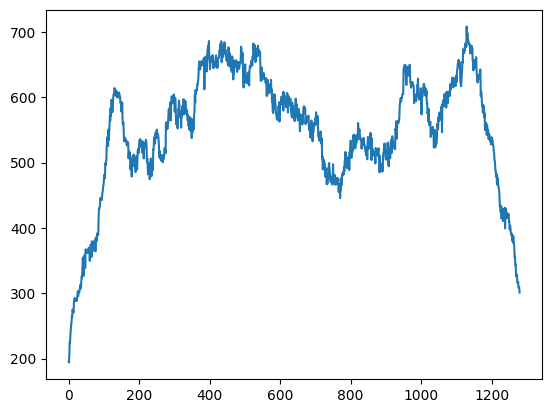

In [ ]:
import matplotlib.pyplot as plt
c = adj[0]@X[0]
plt.plot(c[:,0].detach().numpy())